# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 13 - Minimalizacja funkcji
### Albert Gierlach

Użyta wersja pythona:
* Python 3.8.3 64bit

Użyte biblioteki:
* numpy 1.18.2
* matplotlib 3.2.1

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

<IPython.core.display.Javascript object>

In [2]:
from enum import Enum
import numpy as np
import random
import functools
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib as mtplt

params = {
            'animation.html' : 'jshtml',
            'figure.figsize' : (14, 7),
            'animation.embed_limit': '200' # 400MB
         }
mtplt.rcParams.update(params)

#### 1. Problem komiwojażera
Na początku stworzyłem generator, który posiada możliwość generowania układu punktów 2D za pomocą trzech metod:
* rozkład jednostajny
* rozkład normalny z czterema różnymi grupami parametrów
* dziewięć odseparowanych grup punktów

In [3]:
class Generator:
    def shuffle_list(self, list_):
        random.shuffle(list_)
        return list_

    def generate_uniform(self, n):
        return self.shuffle_list([(np.random.uniform(0, 100), np.random.uniform(0, 100)) for _ in range(n)])

    def generate_normal(self, n):
        res = []

        def one_group(n, mean):
            cov = [
                [5, 0],
                [0, 4]
            ]
            p = []
            for _ in range(n):
                x, y = np.random.multivariate_normal(mean, cov)
                p.append((x, y))

            return p

        means = [
            [0, 0],
            [15, 8],
            [10, 30],
            [35, 15]
        ]

        for mean in means:
            res.extend(one_group(n // 4, mean))

        return self.shuffle_list(res)

    def generate_separated(self, n):
        res = []
        SEPARATOR = 50
        BOUND = 5
        for i in range(3):
            for j in range(3):
                base_p = (i * SEPARATOR, j * SEPARATOR)
                for k in range(n // 9):
                    res.append(
                        (base_p[0] + np.random.uniform(-BOUND, BOUND), base_p[1] + np.random.uniform(-BOUND, BOUND)))

        return self.shuffle_list(res)

Następnie przygotowałem klasę, która pozwala na przeprowadzanie operacji symulowanego wyżarzania. Klasa umożliwia także rysowanie wykresu początkowego i końcowego, a także animację procesu minimalizacji.

In [4]:
class Methods(Enum):
    ARBITRARY_SWAP = 0,
    CONSECUTIVE_SWAP = 1
    

class Solver:
    def __init__(self, points, method):
        self.initial_path = points.copy()

        self.history_path = []
        self.history_cost = []
        self.steps = 0

        if method == Methods.ARBITRARY_SWAP:
            self.desc = "Arbitrary swap"
            self.swap_method = self.arbitrary_swap
        elif method == Methods.CONSECUTIVE_SWAP:
            self.desc = "Consecutive swap"
            self.swap_method = self.consecutive_swap

    def make_pairs(self, list_):
        return zip(list_, list_[1:] + [list_[0]])

    def distance_between_points(self, p1, p2):
        return np.sqrt(np.power(p1[0] - p2[0], 2) + np.power(p1[1] - p2[1], 2))

    def cost(self, path):
        return sum(list(map(lambda x: self.distance_between_points(x[0], x[1]), self.make_pairs(path))))

    def arbitrary_swap(self, path):
        path2 = path.copy()
        pi1, pi2 = random.sample(range(len(path2)), 2)
        path2[pi1], path2[pi2] = path2[pi2], path2[pi1]
        return path2

    def consecutive_swap(self, path):
        path2 = path.copy()
        pi1 = random.choice(range(len(path2)))
        pi2 = (pi1 + 1) % len(path2)
        path2[pi1], path2[pi2] = path2[pi2], path2[pi1]
        return path2

    def accept(self, current_temp, next_temp, start_temp):
        return next_temp < current_temp or np.exp(-np.fabs(next_temp - current_temp) / start_temp) > np.random.uniform()

    def simulated_annealing(self, start_temperature):
        temp_mult = 0.999

        current_path = self.initial_path.copy()
        current_cost = self.cost(current_path)

        self.history_cost = [current_cost]
        self.history_path = [current_path]

        temperature = start_temperature
        i = 0
        while temperature > 1e-6:
            i += 1
            next_path = self.swap_method(current_path)
            next_cost = self.cost(next_path)

            if self.accept(current_cost, next_cost, temperature):
                current_path = next_path
                current_cost = next_cost
                self.history_path.append(current_path)
                self.history_cost.append(current_cost)
                self.steps = i

            temperature *= temp_mult

    def draw(self):
        if len(self.history_cost) > 0:
            best_path = self.history_path[self.history_cost.index(min(self.history_cost))]
            self.draw_internal(best_path)
        else:
            best_path = self.initial_path
            self.draw_internal(best_path, True)

    def draw_internal(self, path, initial=False):
        xs, ys = [p[0] for p in path], [p[1] for p in path]
        xs.append(path[0][0])  # close path
        ys.append(path[0][1])  # close path
        plt.plot(xs, ys, 'o')
        plt.plot(xs, ys)
        if not initial:
            plt.title("{} - {} steps - path length: {:.4f}".format(self.desc, self.steps, self.cost(path)))
        else:
            plt.title("Initial - path length: {:.4f}".format(self.cost(path)))
        plt.show()

    def animate(self):
        fig, ax = plt.subplots()
        plt.close(fig)

        def draw_frame(frame_index):
            ax.clear()
            path = self.history_path[frame_index]
            xs, ys = [p[0] for p in path], [p[1] for p in path]
            ax.plot(xs, ys, 'o')
            xs.append(path[0][0])  # close path
            ys.append(path[0][1])  # close path
            ax.plot(xs, ys)
            ax.set_title(
                "{} - {} steps - path length: {:.4f}".format(self.desc, self.steps, self.history_cost[frame_index]))

        return animation.FuncAnimation(fig, draw_frame,
                                       interval=50,
                                       frames=len(self.history_cost),
                                       repeat=False)

In [5]:
gen = Generator()
nn = [10, 30, 50]

def present_solution(points, temp=2000):
    s = Solver(points, Methods.ARBITRARY_SWAP)
    s.draw()
    s.simulated_annealing(temp)
    s.draw()

    s = Solver(points, Methods.CONSECUTIVE_SWAP)
    s.simulated_annealing(temp)
    s.draw()

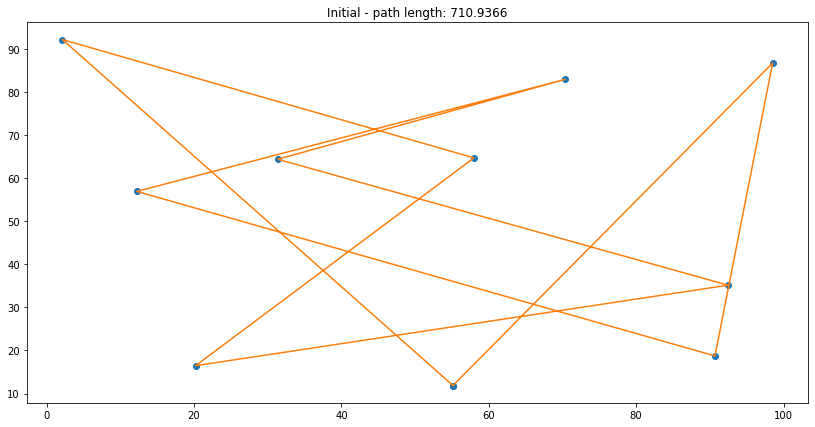

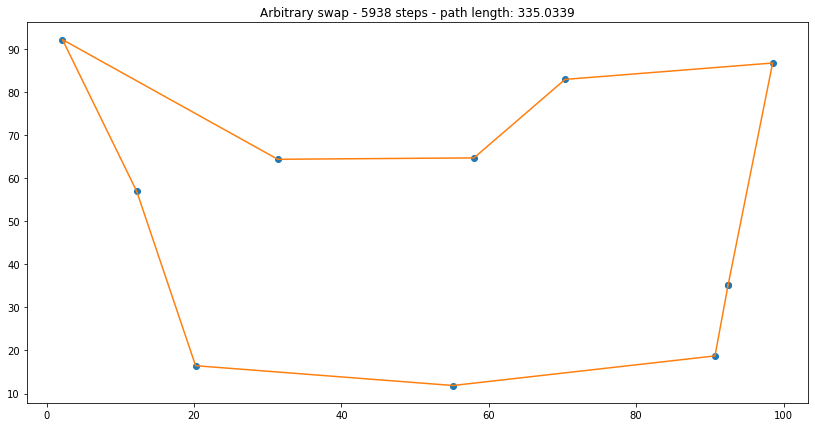

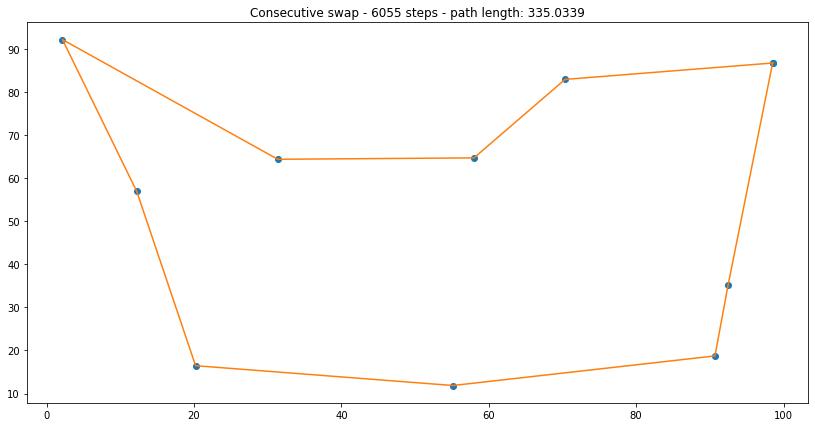

In [6]:
points = gen.generate_uniform(nn[0])
present_solution(points)

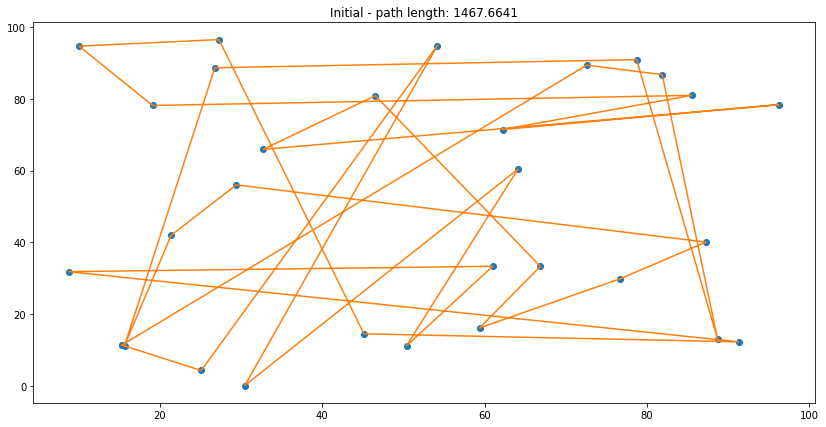

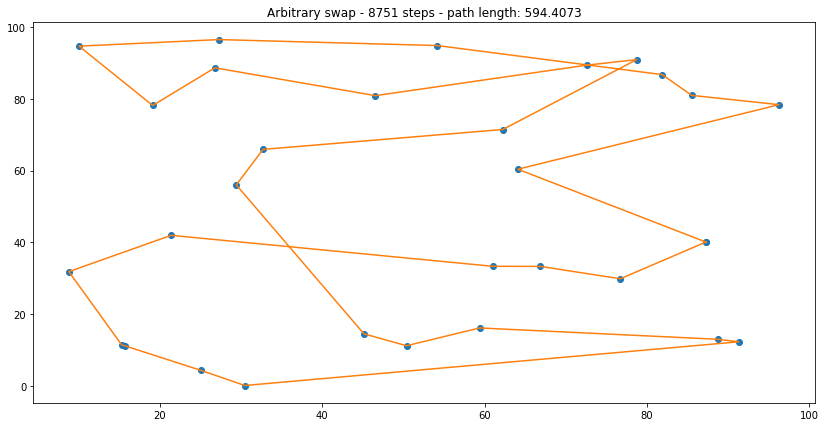

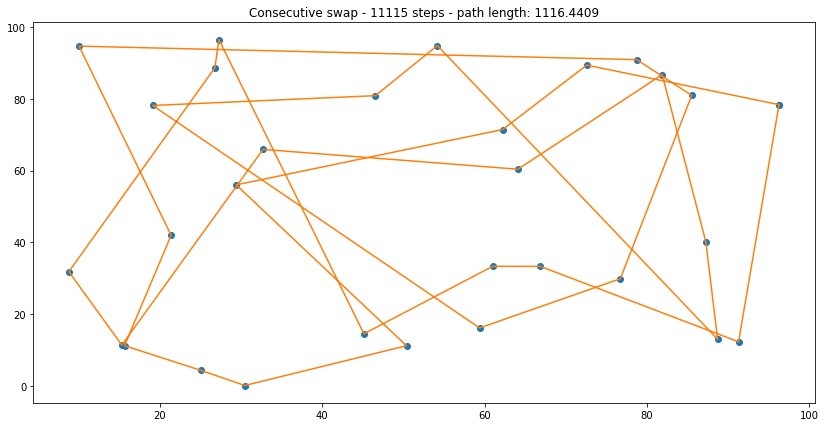

In [7]:
points = gen.generate_uniform(nn[1])
present_solution(points)

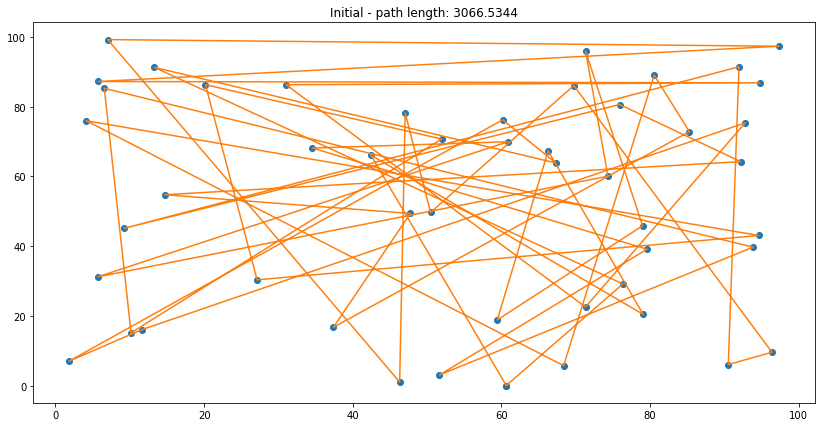

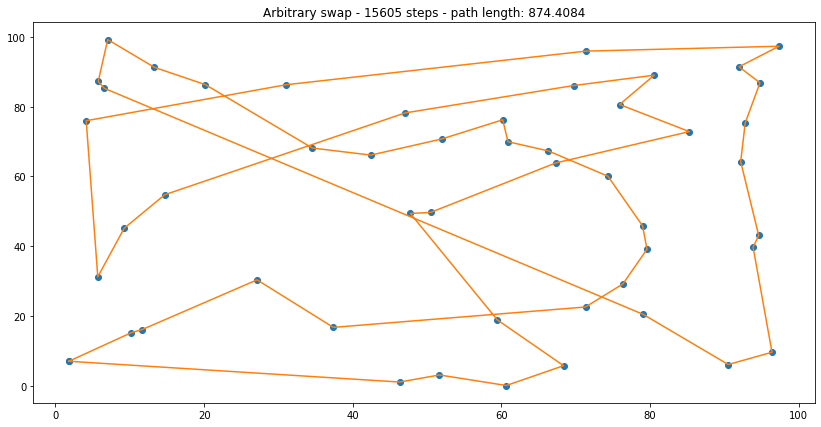

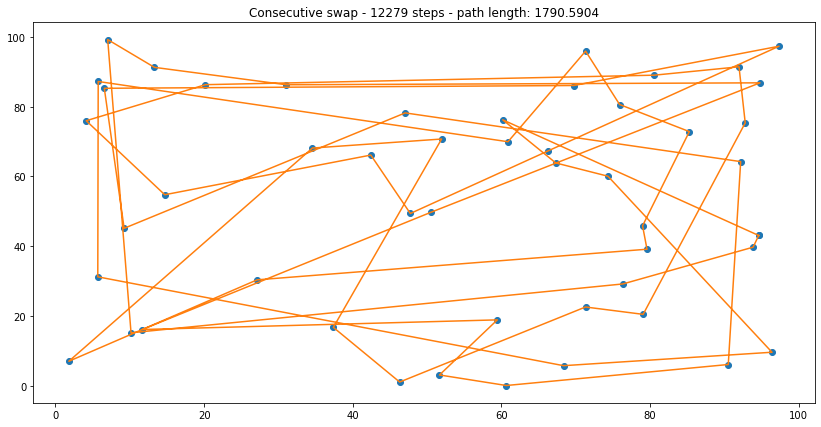

In [8]:
points = gen.generate_uniform(nn[2])
present_solution(points)

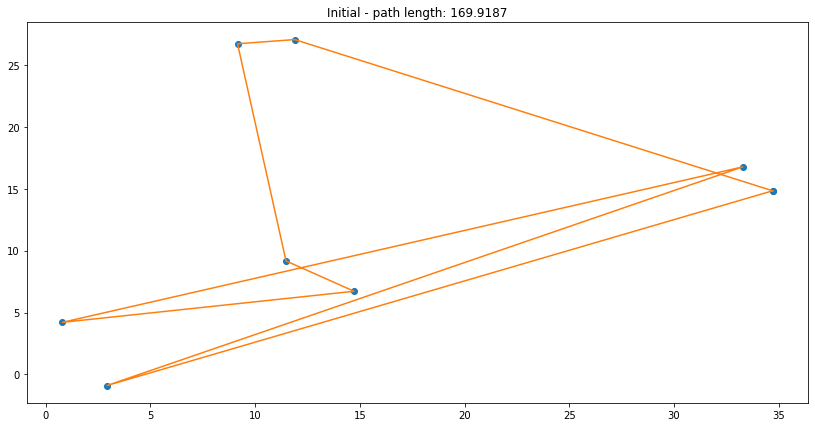

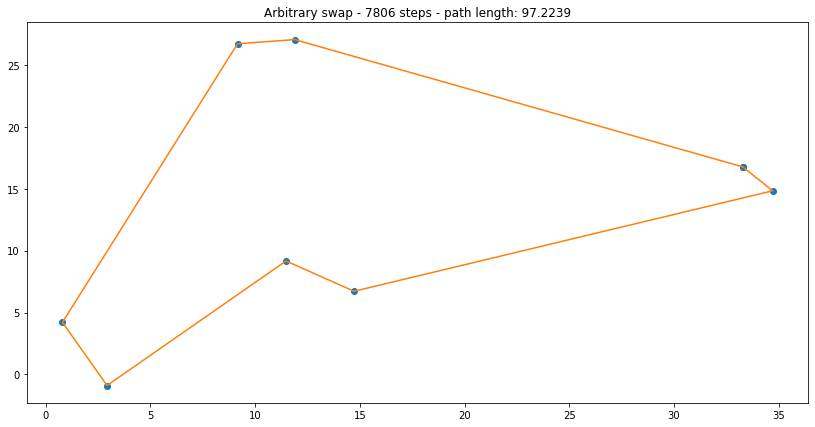

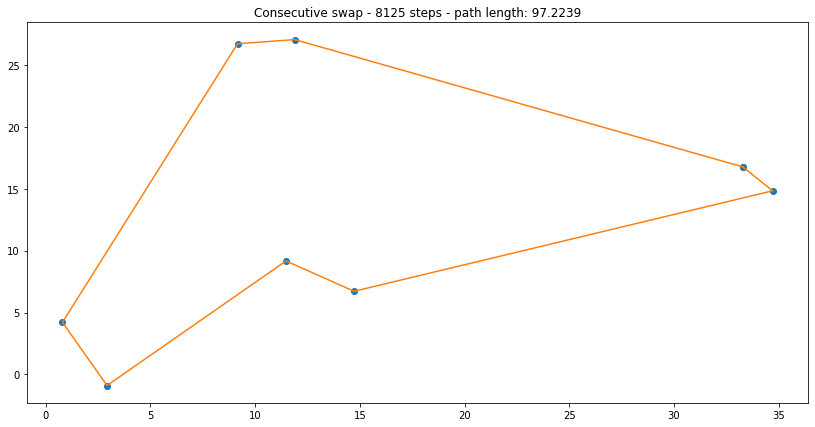

In [9]:
points = gen.generate_normal(nn[0])
present_solution(points)

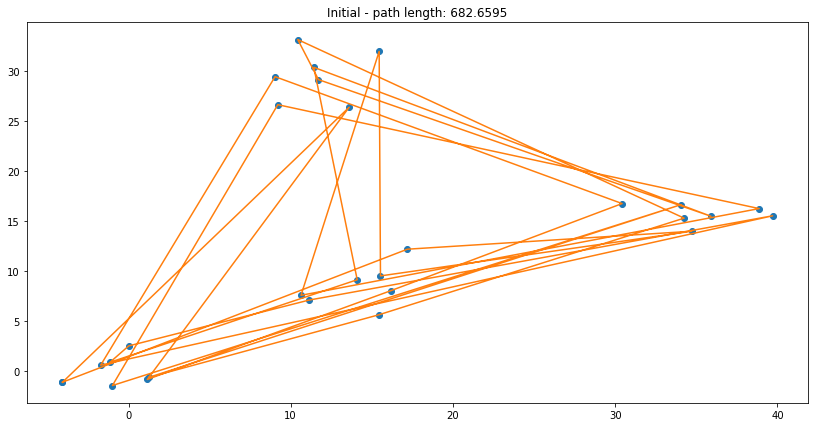

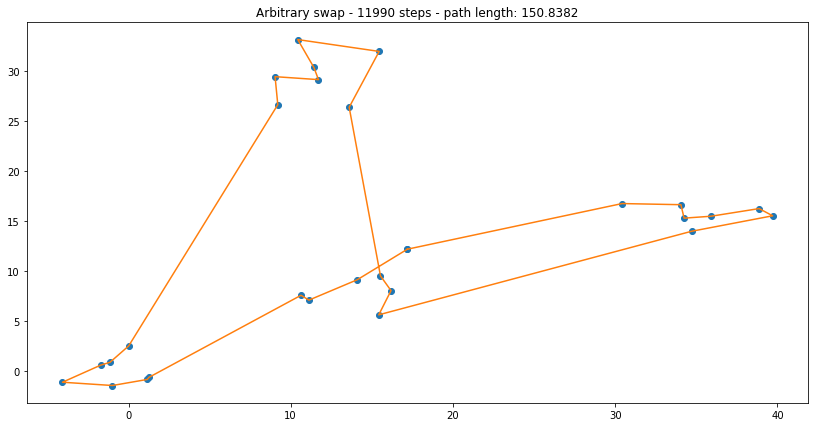

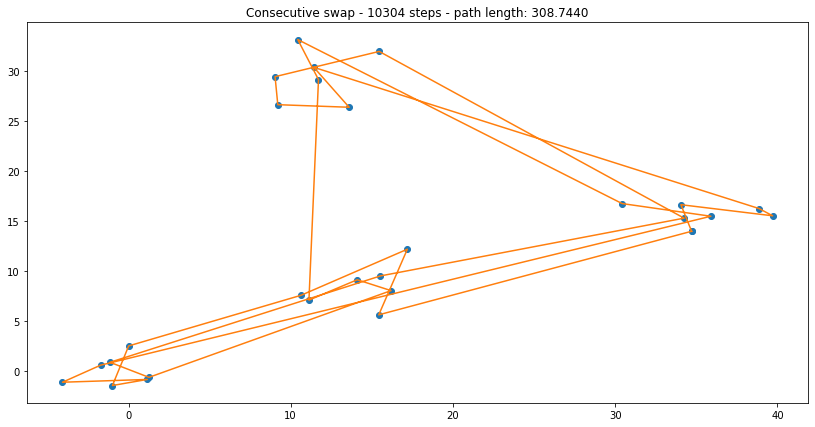

In [10]:
points = gen.generate_normal(nn[1])
present_solution(points)

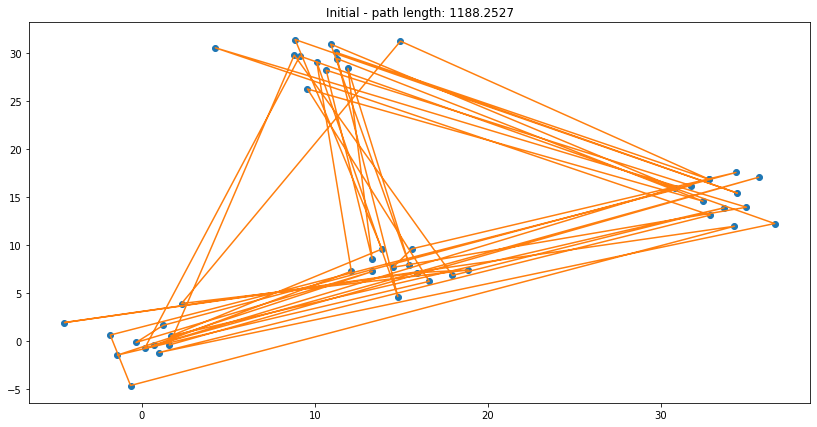

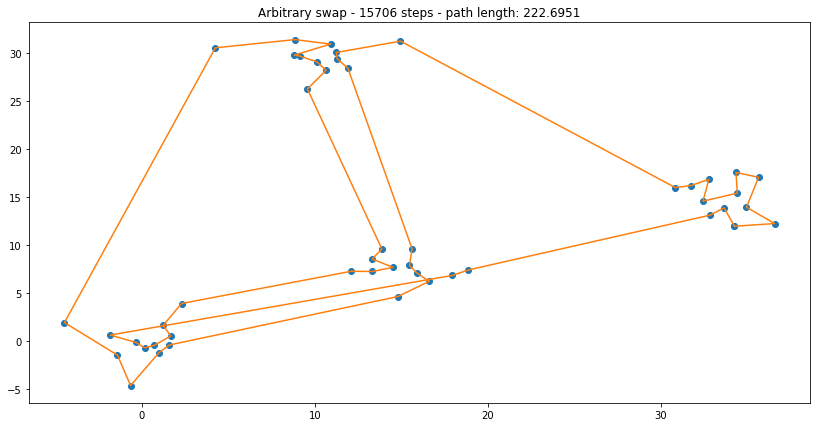

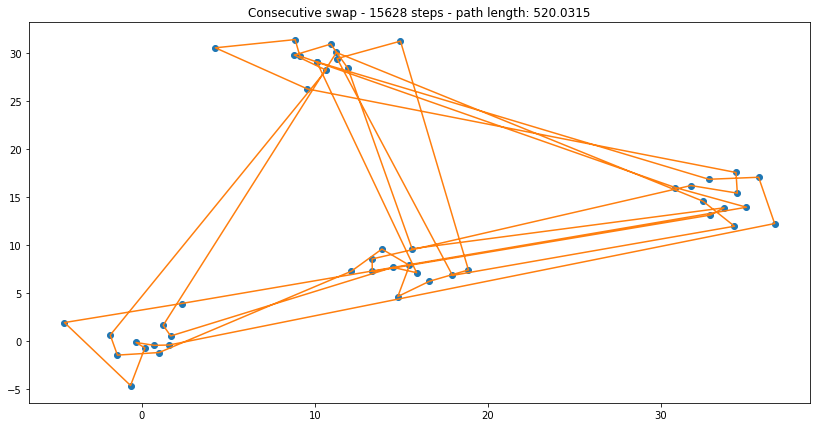

In [11]:
points = gen.generate_normal(nn[2])
present_solution(points)

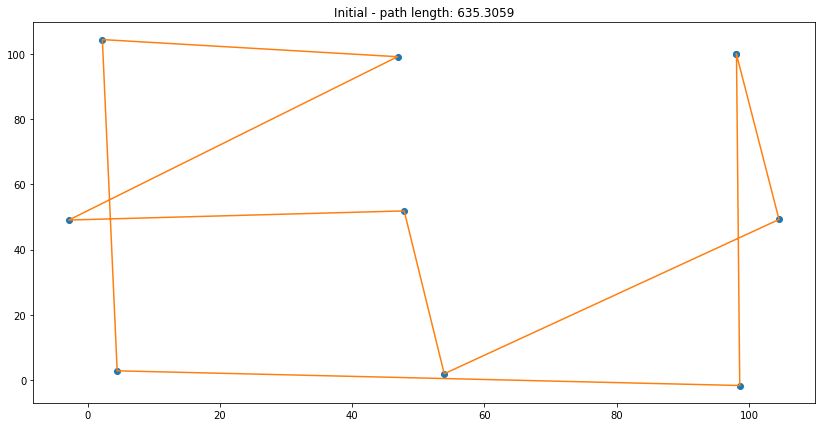

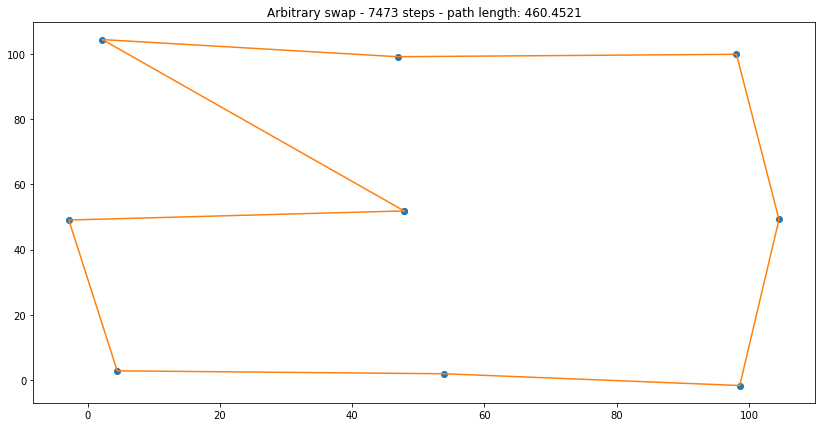

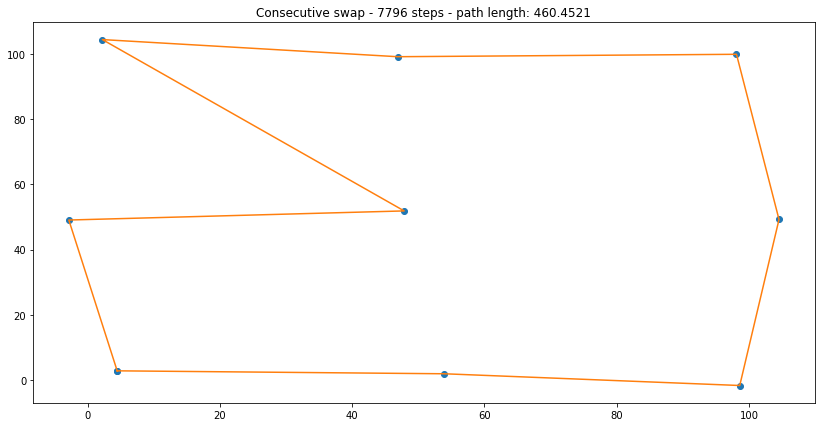

In [12]:
points = gen.generate_separated(nn[0])
present_solution(points)

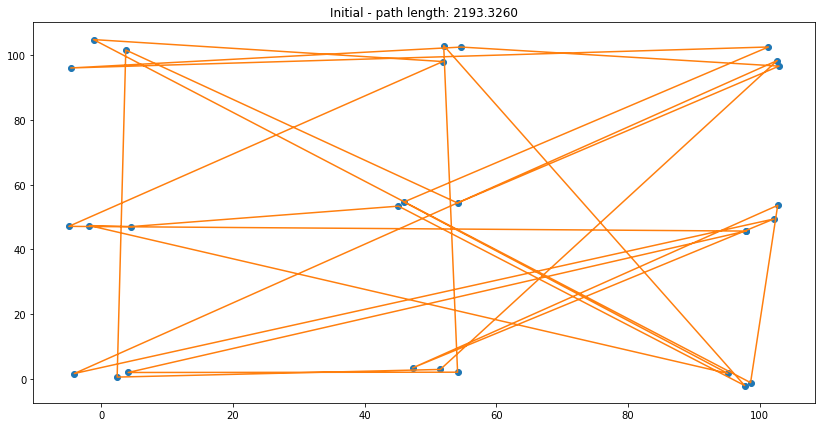

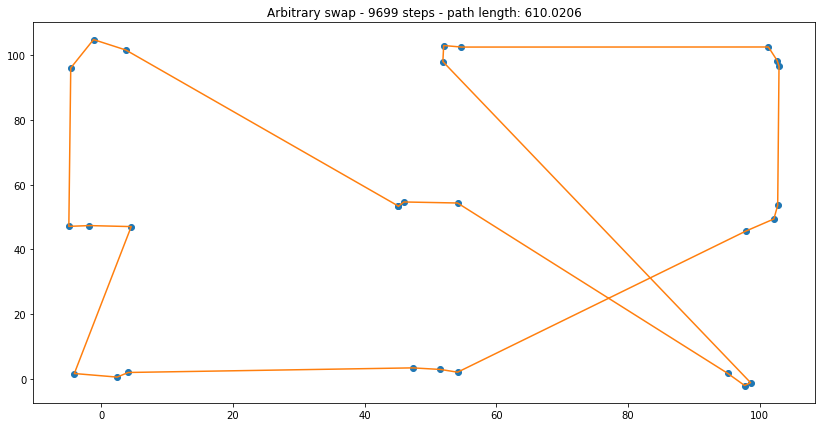

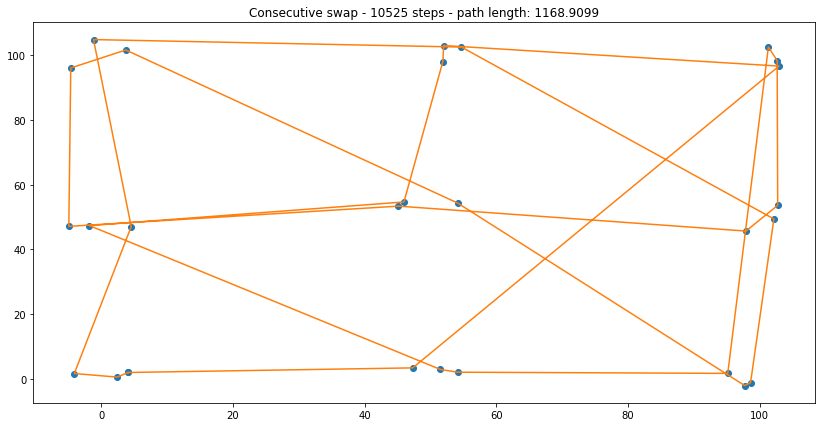

In [13]:
points = gen.generate_separated(nn[1])
present_solution(points)

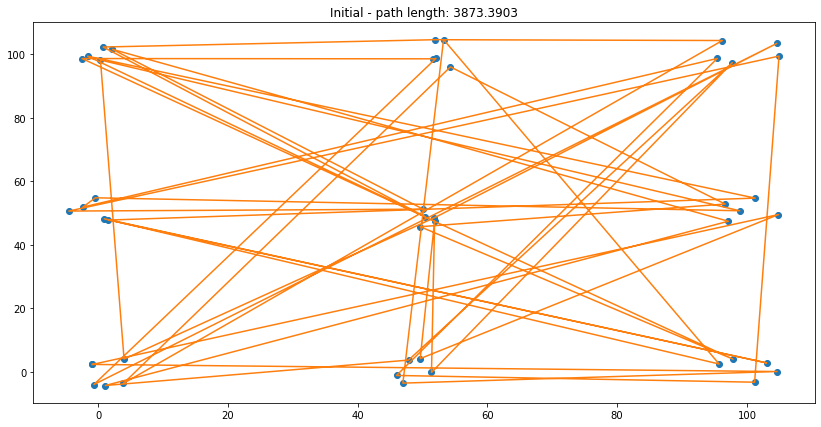

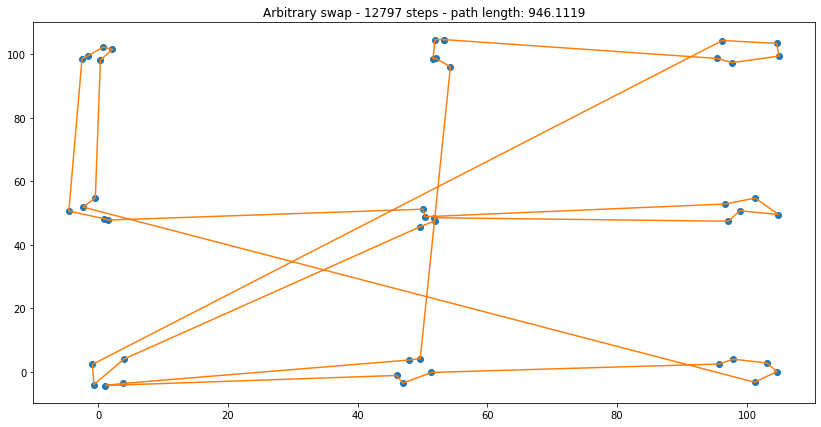

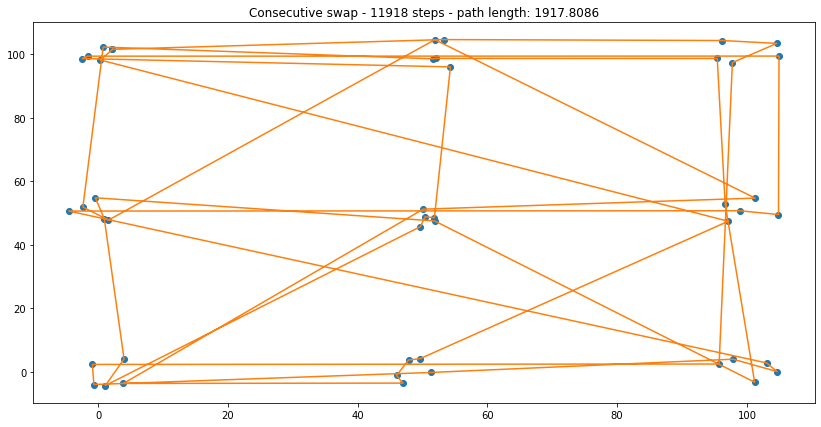

In [14]:
points = gen.generate_separated(nn[2])
present_solution(points)

Porównując powyższe grafy można dojść do wniosku, że arbitrary swap daje dużo lepsze wyniki minimalizacji problemu komiwojażera. W większości przypadków arbitrary swap potrzebuje mniej iteracji niż consecutive swap. Możliwe, że wyższa wartość początkowej temperatury wpłynie korzystnie na skuteczność metody consecutive swap. Poniżej porównałem wpływ startowej temperatury (drugi parametr funkcji present_solution) na wyniki poszczególnych algorytmów.

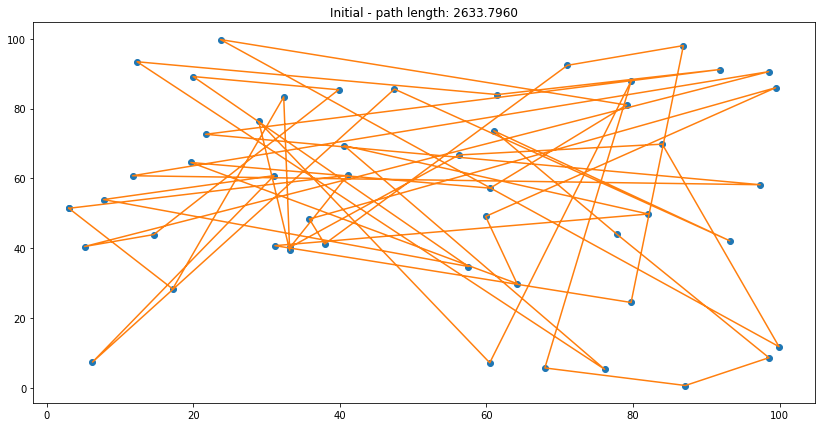

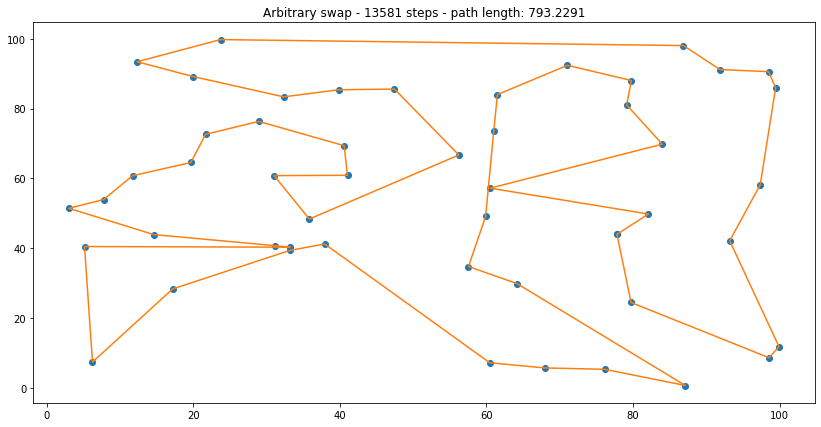

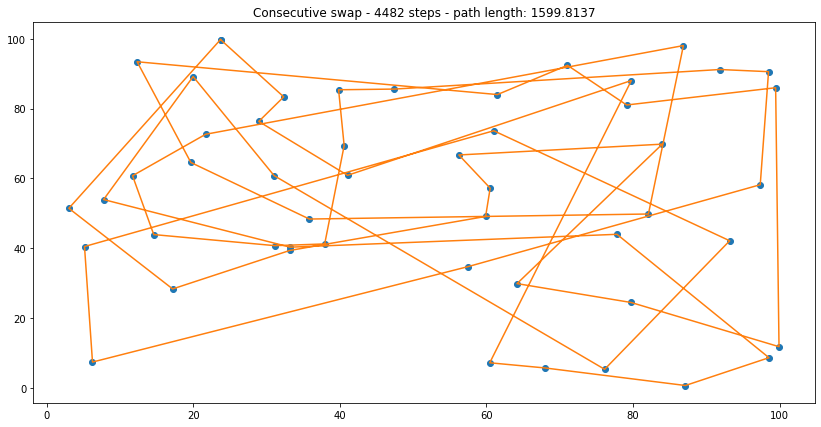

In [15]:
points = gen.generate_uniform(nn[2])
present_solution(points, 100)

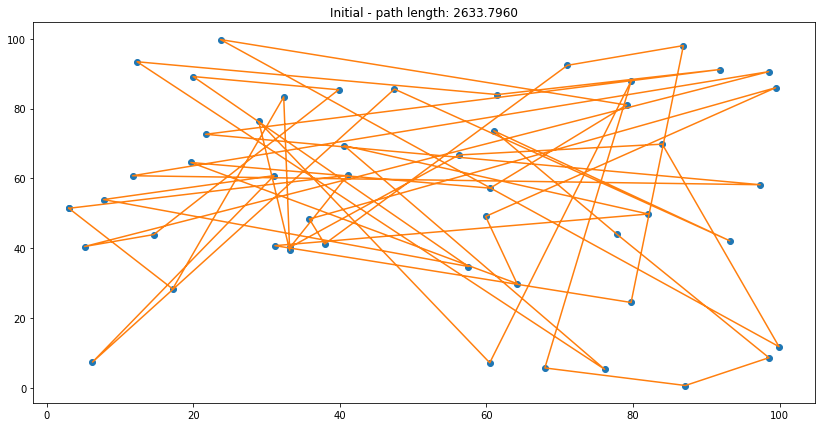

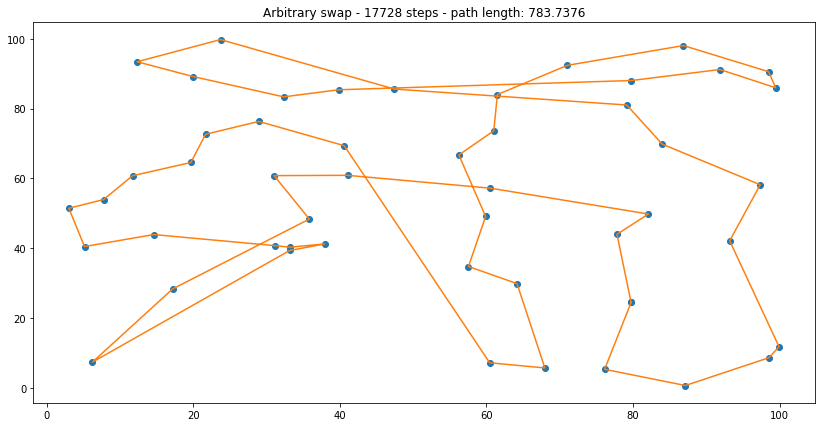

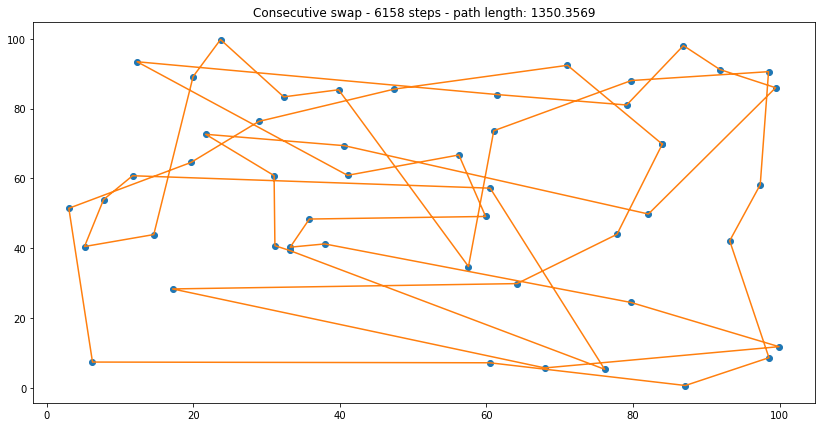

In [16]:
present_solution(points, 500)

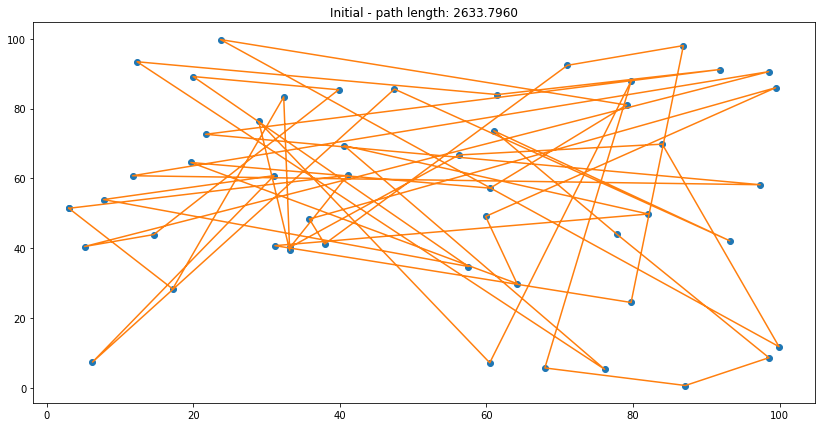

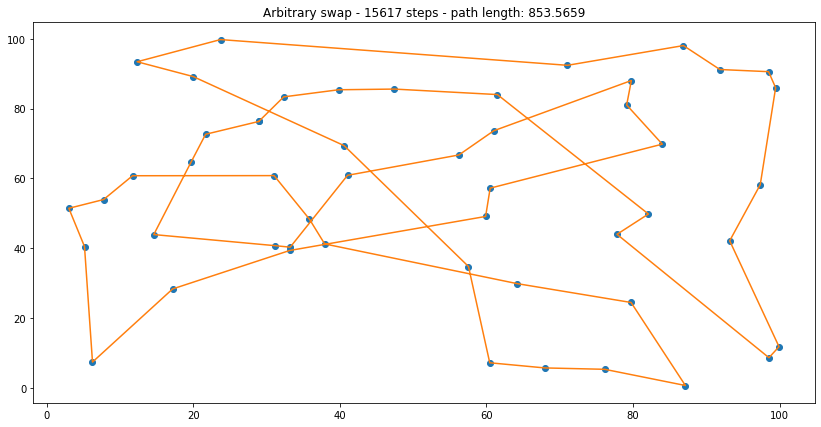

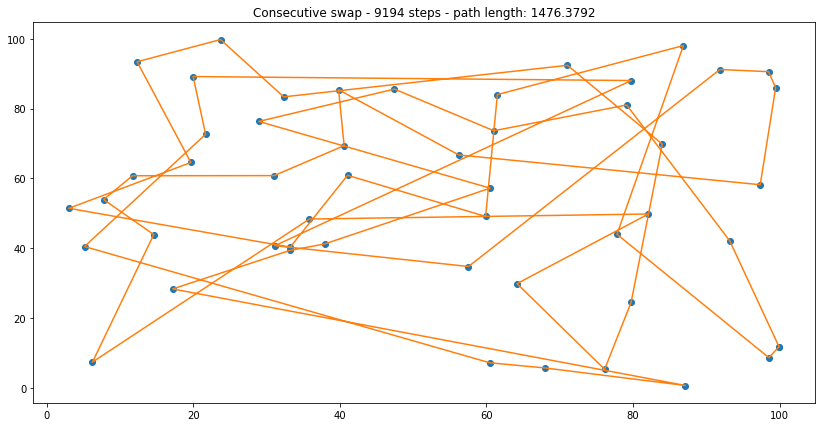

In [17]:
present_solution(points, 1000)

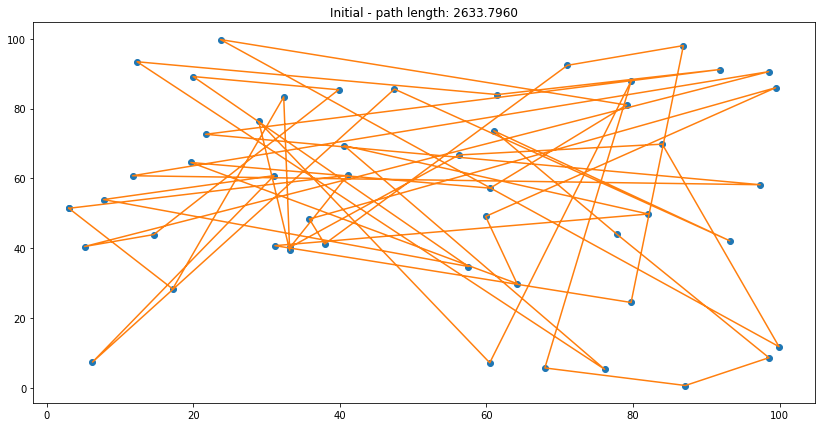

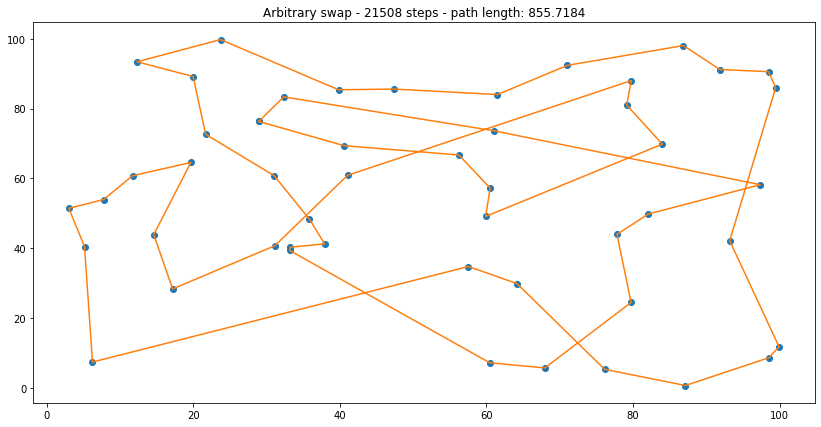

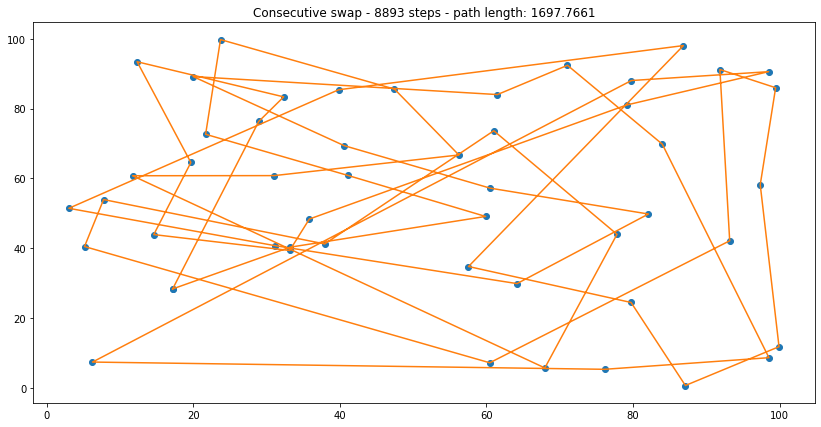

In [18]:
present_solution(points, 3000)

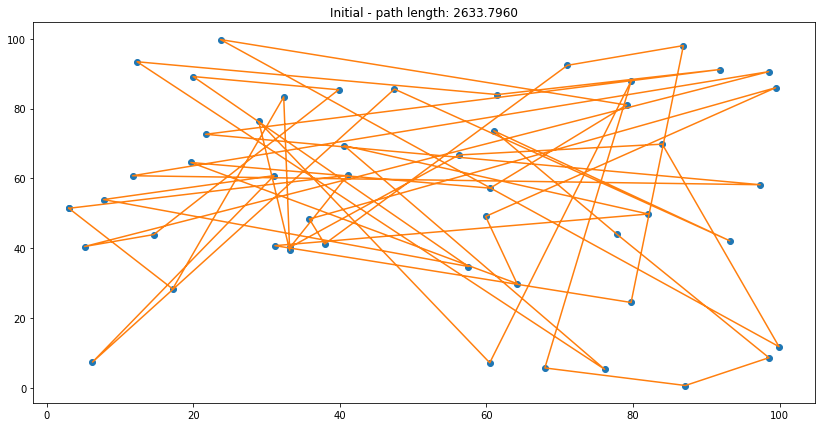

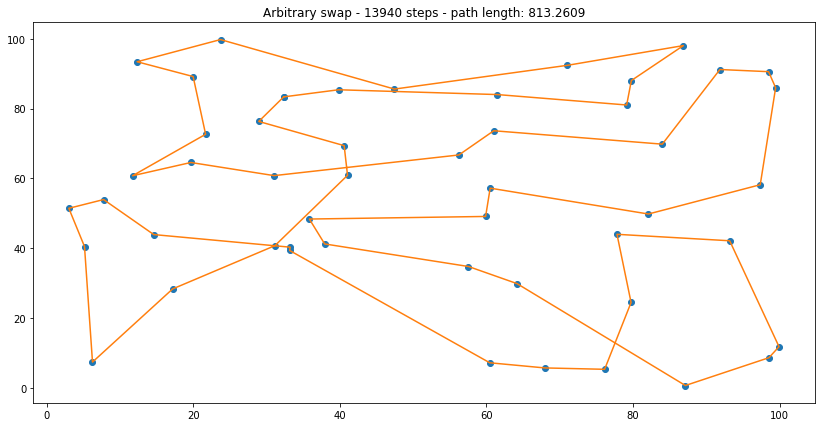

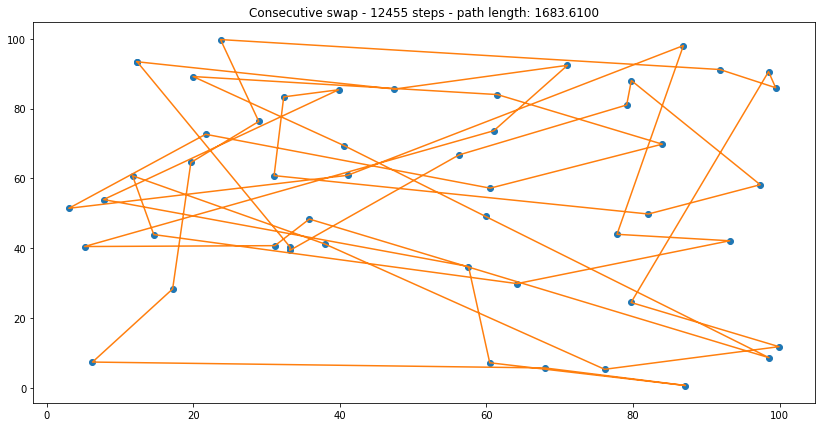

In [19]:
present_solution(points, 10000)

Niestety jak się okazało, temperatura początkowa nie spowodowała, że consecutive swap zbliżył się do arbitrary swap'a. Mimo tego wyższa wartość początkowej temperatury pozwala na większą minimalizację z uwagi na większą liczbę iteracji zanim temperatura zmaleje do okolic zera oraz z uwagi na prawdopodobieństwo zaakceptowania większej liczby stanów, które niekoniecznie są lepsze w obecnej iteracji, ale dzięki nim możemy dojść do innych dobrych (lub najlepszych) wyników.

Przedstawiam wizualizację działania algorytmu dla jednego z przykładów (renderowanie animacji może chwilę potrwać):

In [ ]:
points = gen.generate_uniform(15)
s = Solver(points, Methods.ARBITRARY_SWAP)
s.simulated_annealing(100)
s.animate()